In [1]:
import numpy as np
import pandas as pd
from numpy import nan

from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier,GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import KFold,cross_val_score,StratifiedKFold
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,cross_validate,cross_val_predict,RandomizedSearchCV
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,auc
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score,precision_recall_curve,accuracy_score,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold,RFECV
from imblearn.over_sampling import SMOTE,RandomOverSampler,ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2,mutual_info_classif
from sklearn.calibration import CalibratedClassifierCV,calibration_curve,CalibrationDisplay
from sklearn.metrics import multilabel_confusion_matrix
import xgboost as xgb
import os

from sklego.meta import Thresholder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import cartopy.crs as ccrs

In [2]:
import rioxarray as rxr
import matplotlib.gridspec as gridspec
from metpy.plots import USCOUNTIES
import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [3]:
from min_distance import *

In [4]:
codeDir = os.path.dirname(os.path.abspath(os.getcwd()))
parentDir = os.path.dirname(codeDir)

open training and label

In [5]:
df = pd.read_feather(parentDir+'\\intermediate_datadev2')

In [13]:
order = ['max_mrms', 'median_int_point', 'std_int_point','var_int_point', 'mean_int_point',
         'total_accum_atgage','median_accum_point','std_accum_point', 'var_accum_point', 'mean_accum_point',
        'duration','month', 'hour',
       'latitude', 'longitude',  
         'mult_correct', 'RQI',
       'point_elev', 'point_aspect','point_slope', 
         'max', 'median','std', 'var', 'mean', 
         'accum_max_storm','accum_median_storm', 'accum_std_storm', 'accum_var_storm','accum_mean_storm', 
         'duration_storm', 
         'area', 'axis_major_length', 'axis_minor_length',
         'eccentricity', 'velocity',
       'elevation_foot', 'storm_elev',  'storm_aspect','slope_foot'
       ]

In [14]:
get_summary=df.reindex(columns=order)

In [15]:
for i in get_summary.columns:
    print(get_summary[i].median())

1.2372107617557049
0.40000004041939974
0.34659302849869994
0.12012672872469385
0.5244444806128741
0.5200000032782555
0.023333333432674408
0.016069181866674453
0.0002582186058642591
0.030800275323060105
85.0
7.0
8.0
39.0449999999996
254.20499899999703
1.0
0.9
2079.0
194.03624
3.3789608
55.36000061035156
0.5333333611488342
1.9182593027704598
4.027821779251099
1.0222479104995728
40.150001525878906
1.1966667175292969
3.532348636663053
14.045316696166992
2.5103503465652466
614.5
46441.0
291.83888214207303
175.63940085547807
0.7931066655602554
144.37056274193787
2427.7122075754573
2601.0
173.47259521484375
9.33839225769043


In [6]:
# remove samples where max mrms intensity < min possible gage intensity
min_int = pd.read_feather(parentDir+'\\min_intensity_gage')
min_int['gage_id'] = min_int.index
min_int.min_intensity = min_int.min_intensity
df['min_int'] = [min_int.loc[min_int.gage_id==df.gage_id[i][0]].min_intensity.values[0] for i in df.index]

df = df.query('max_mrms > min_int')

#df = df.reset_index(drop=True).drop(columns=['min_int','gage_id','max_accum_atgage'])
df = df.reset_index(drop=True).drop(columns=['min_int','max_accum_atgage'])
df.gage_id = [df.gage_id[i][0] for i in df.index]

In [7]:
# remove multiple gages in same MRMS grid
test = df.groupby(['latitude','longitude']).agg(list)
test['num_gage'] = [len(np.unique(test.gage_id[i])) for i in test.index]
test['i_gage'] = [np.unique(test.gage_id[i]) for i in test.index]

dup = test.loc[test.num_gage>1].reset_index().i_gage
gage_dup = [dup[i][1] for i in dup.index]
df = df.loc[~df.gage_id.isin(gage_dup)]

In [103]:
'''df = df.loc[df.AR_peak!=0]
df = df.reset_index(drop=True).drop(columns=['gage_id','max_accum_atgage'])'''


"df = df.loc[df.AR_peak!=0]\ndf = df.reset_index(drop=True).drop(columns=['gage_id','max_accum_atgage'])"

In [104]:
'''# remove samples less than 1km apart, keep first
distance_lessthan = 1
df = remove_closest(df,distance_lessthan)'''


'# remove samples less than 1km apart, keep first\ndistance_lessthan = 1\ndf = remove_closest(df,distance_lessthan)'

In [8]:
# shift lon to 255.5, was 255 when i developed dataset
df = df.loc[df.longitude<255.5]

In [9]:
df['label']=0
df.loc[(df.AR_peak<=1/.3)&(df.AR_peak>=.3)&(df.AR_accum<=1/.25)&(df.AR_accum>=.25),['label']]=1

df = df.loc[(df.AR_peak!=np.inf)&(df.AR_accum!=np.inf)]
df = df.drop(columns=['AR_peak','AR_accum'])
#df = df.drop(columns=['std_int_point','std_accum_point','mean_accum_point','accum_mean_storm','accum_std_storm'])

df = df.dropna()

In [9]:
'''gage_unique = df.gage_id.unique()
train = np.random.choice(gage_unique,size=int(.8*len(gage_unique)),replace=False)
test = set(gage_unique)-set(train)
train = df.loc[df.gage_id.isin(train)]
test = df.loc[df.gage_id.isin(test)]

scaler = StandardScaler()

cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)

X_train, X_test, y_train, y_test = scaler.fit_transform(train.drop(columns=['label','gage_id'])),scaler.fit_transform(test.drop(columns=['label','gage_id'])),train.label,test.label'''


In [9]:
data = df.drop(columns=['label','gage_id'])
labels = df.label.values
scaler = StandardScaler()
data=scaler.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)

open predict dataset

In [63]:
predict = pd.read_feather(parentDir+'\\predict')

predict = predict.rename(columns={'correction':'mult_correct'})
predict=predict.reindex(columns=df.columns.drop(['label','gage_id']))

predict=predict.dropna()
#predict=predict.loc[predict.max_mrms>1]

predict_s =scaler.fit_transform(predict)

In [33]:
'''# frequency of good label
c = predict.groupby(['latitude','longitude']).count()
c1 = predict.groupby(['latitude','longitude']).agg(list).label.values
f = [len(np.nonzero(c1[i]))/len(c1[i]) for i in range(len(c1))]
c['frequency'] = f
frequency = (c.iloc[:,-1]).to_xarray()'''

0.0266666691750288

In [32]:
'''# predict
clf = GradientBoostingClassifier(n_estimators= 100, max_depth= 8, learning_rate= 0.05,random_state=0)
pipe = Pipeline([
("model", Thresholder(clf, threshold=0.7))
])

pipe.fit(data,labels)
predict['label'] = pipe.predict(predict_s)
#predict['label'] = pipe.predict_proba(predict_s)[:, 0]
#predict['label'] = clf.decision_function(predict_s)'''


In [17]:
'''# predict
clf = xgb.XGBClassifier(subsample= 0.8, n_estimators= 64, min_child_weight= 1,
                      max_depth= 8, learning_rate= 0.1, gamma= 1, colsample_bytree= 0.6)

pipe = Pipeline([
("model", Thresholder(clf, threshold=0.7))
])
pipe.fit(data,labels)

pipe.predict(predict_s)
print(len(np.where(pipe.predict(predict_s)==1)[0])/len(predict))'''


0.1794163052267882


compare variation of features between labels

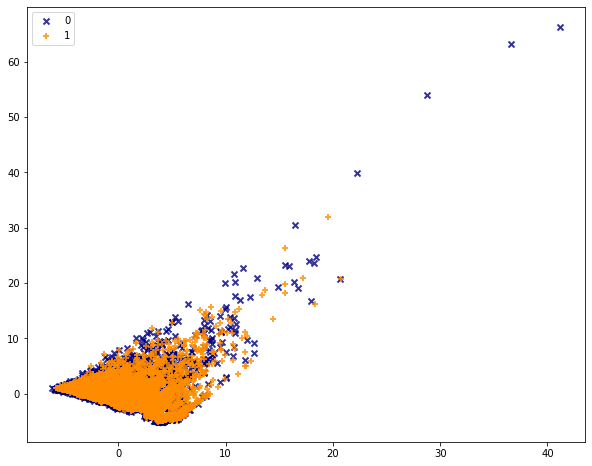

In [13]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(data)

colors = ["navy", "darkorange"]
markers=['x','+']
fig = plt.figure(1, figsize=(10,8))

for marker,color, i in zip(markers,colors, [0,1]):
    plt.scatter(
        X_r[labels == i, 0], X_r[labels == i, 1],color=color, marker=marker,alpha=0.8, lw=2, label=i
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)

In [11]:
t_sne = TSNE(n_components=2,random_state=1)
S_t_sne = t_sne.fit_transform(data)

C:\Users\GSCOB\miniconda3\envs\radar\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\GSCOB\miniconda3\envs\radar\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


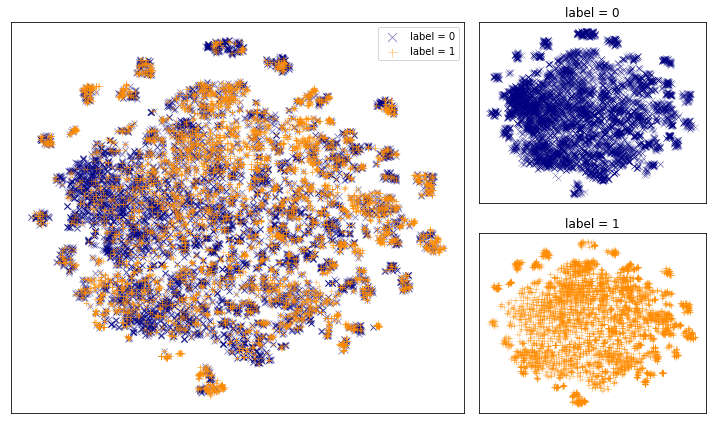

In [13]:
colors = ["navy", "darkorange","darkgreen" ]
markers=['x','+','*']

fig, axs = plt.subplots(ncols=2, nrows=2, gridspec_kw={'width_ratios': [2, 1]},figsize=(10,6))
gs = axs[0,1].get_gridspec()
# remove the underlying axes
for ax in axs[0:, 0]:
    ax.remove()
axbig = fig.add_subplot(gs[0:, 0])


for marker,color, i in zip(markers,colors, [0,1]):
    axbig.scatter(
        S_t_sne[labels == i, 0], S_t_sne[labels == i, 1],color=color, marker=marker,alpha=0.5, lw=.8, label=i
    )
plt.legend(['label = 0','label = 1'],loc="best", shadow=False,scatterpoints=1,markerscale=1.5)
#plt.title("t-sne")

for marker,color, i in zip(markers,colors, [0]):
    axs[0,1].scatter(
        S_t_sne[labels == i, 0], S_t_sne[labels == i, 1],color="navy", marker='x',alpha=0.5, lw=.5, label=i
    )
for marker,color, i in zip(markers,colors, [1]):
    axs[1,1].scatter(
        S_t_sne[labels == i, 0], S_t_sne[labels == i, 1],color="darkorange", marker='+',alpha=0.5, lw=.5, label=i
    )
axbig.legend(['label = 0','label = 1'],loc="best", shadow=False,scatterpoints=1,markerscale=1.5)
axs[0,1].set_title('label = 0')
axs[1,1].set_title('label = 1')

axbig.set_xticks([])
axbig.set_yticks([])
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])
fig.tight_layout()
fig.savefig("tsne.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

test many models using defaults

In [128]:
names = [
    "Nearest Neighbors",
    #"RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Bagged Tree",
    "Neural Net",
    "AdaBoost",
    "Logistic Regression",
    "xgboost",
    "Gradient Boosting",
    "SVC"
]

classifiers = [
    KNeighborsClassifier(),
    #SVC(gamma='auto',random_state=0),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    BaggingClassifier(random_state=0),
    MLPClassifier(random_state=0),
    AdaBoostClassifier(random_state=0),
    LogisticRegression(random_state=0),
    xgb.XGBClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0),
    SVC(random_state=0)
]

In [129]:
# baseline
f1 = []
accuracy = []
roc = []
precision = []
recall = []
good = []

for name, clf in zip(names, classifiers):
    clf = clf
    clf.fit(X_train,y_train)
    x = cross_validate(clf,X_train,y_train, cv = cv,
                     scoring=['f1','accuracy','roc_auc','precision','recall'])
    
    f1.append(x['test_f1'].mean())
    accuracy.append(x['test_accuracy'].mean())
    roc.append(x['test_roc_auc'].mean())
    precision.append(x['test_precision'].mean())
    recall.append(x['test_recall'].mean())
    good.append(len(np.where(clf.predict(predict_s)==1)[0])/len(predict))
    
d = {'names':names,'f1':f1,'accuracy':accuracy,'roc_auc':roc,'precision':precision,'recall':recall, 'good':good}
pd.DataFrame(data=d).sort_values('accuracy',ascending=False)

C:\Users\GSCOB\miniconda3\envs\radar\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\GSCOB\miniconda3\envs\radar\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\GSCOB\miniconda3\envs\radar\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\GSCOB\miniconda3\envs\radar\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\GSCOB\miniconda

,names,f1,accuracy,roc_auc,precision,recall,good
6,Logistic Regression,0.580830,0.626287,0.696582,0.627729,0.581047,0.399660
9,SVC,0.553586,0.589763,0.661627,0.582995,0.581708,0.486350
0,Nearest Neighbors,0.526896,0.560672,0.580812,0.543980,0.547705,0.452659
4,Neural Net,0.535100,0.553752,0.595510,0.535302,0.577181,0.595845
2,Random Forest,0.508984,0.552736,0.571741,0.536463,0.540198,0.702258
5,AdaBoost,0.504869,0.541242,0.560655,0.527171,0.540620,0.626169
8,Gradient Boosting,0.477227,0.518150,0.530935,0.501705,0.517185,0.723376
3,Bagged Tree,0.430925,0.491397,0.460485,0.474118,0.436719,0.513269
1,Decision Tree,0.464809,0.485091,0.486324,0.463634,0.508138,0.523236
7,xgboost,0.425740,0.469321,0.471401,0.446491,0.463846,0.669425


### improve results for top 3

In [130]:
names = [
    "Random Forest",
    "xgboost",
    "Gradient Boosting",
]

classifiers = [

    RandomForestClassifier(random_state=0),
    xgb.XGBClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0),
]

feature selection

In [144]:
# recursive feature search
min_features_to_select = 5  # Minimum number of features to consider
n_scores = []
ts=[]
std_ts=[]

optimal_num = []

for name, clf in zip(names, classifiers):

    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="roc_auc",
        # scoring="accuracy",
        min_features_to_select=min_features_to_select,
        n_jobs=2,
        
    )
    rfecv.fit(X_train,y_train)

    optimal_num.append(rfecv.n_features_)

    n_scores.append(len(rfecv.cv_results_["mean_test_score"]))
    ts.append(rfecv.cv_results_["mean_test_score"])
    std_ts.append(rfecv.cv_results_["std_test_score"])

C:\Users\GSCOB\miniconda3\envs\radar\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\GSCOB\miniconda3\envs\radar\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

C:\Users\GSCOB\miniconda3\envs\radar\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AttributeError: coef_ is only available when using a linear kernel

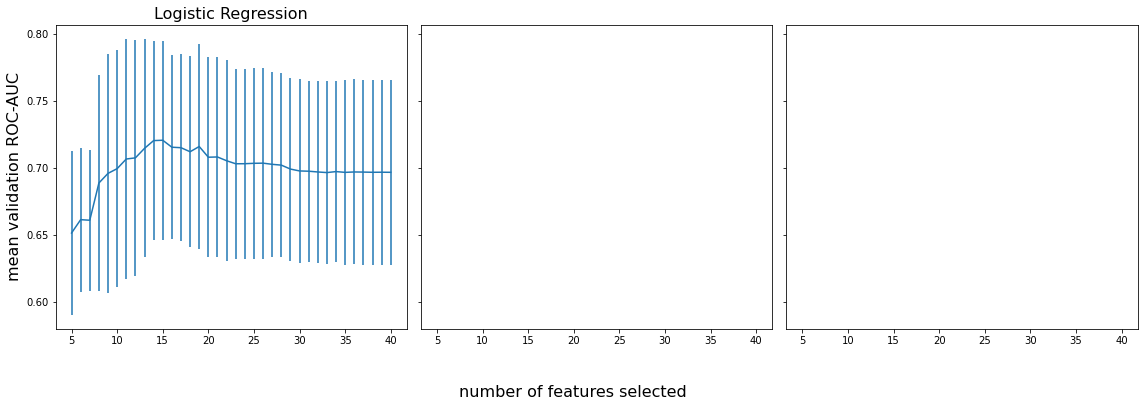

In [141]:
fig, axs = plt.subplots(1,3, figsize=(16,5), facecolor='w', edgecolor='k',sharey=True,sharex=True)
 
fig.subplots_adjust(wspace=.3)
axs = axs.ravel()    

fig.text(0.5,-.1, "number of features selected", ha="center", va="center",fontsize=16)
for i,name in enumerate(names):   
    #axs[i].set_xlabel("number of features selected")

    axs[i].errorbar(
        range(min_features_to_select, n_scores[i] + min_features_to_select),
        ts[i],
        yerr=std_ts[i],
    )
    axs[i].set_title(name, fontsize=16)
axs[0].set_ylabel("mean validation ROC-AUC", fontsize=16)  

fig.tight_layout()
    
fig.savefig("rfecv.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

In [12]:
# recursive feature search, save feature importance
fi_preht = []
for name, clf in zip(names, classifiers):
    clf = clf

    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="roc_auc",
        min_features_to_select=40,
        n_jobs=2,
    )
    rfecv.fit(X_train,y_train)

    feature_importances = pd.DataFrame(rfecv.estimator_.feature_importances_,
                                       index = df.drop(columns=['label','gage_id']).columns,
                                       columns=[name+'prefsimportance']).sort_values(name+'prefsimportance',
                                                                           ascending=False)

    fi_preht.append(feature_importances)

remove features and test 3 models

In [32]:
df2 = df.drop(columns = fi_preht[1].tail(n=40-optimal_num[1]).index)

data = df2.drop(columns=['label','gage_id'])
labels = df2.label.values
scaler = StandardScaler()
data=scaler.fit_transform(data)

X_train2, X_test2, y_train2, y_test2 = train_test_split(data, labels, test_size=0.2, random_state=42)

In [33]:
clf = xgb.XGBClassifier(random_state=0)
clf.fit(X_train,y_train)
x = cross_validate(clf,X_train,y_train, cv = cv,
                 scoring=['f1','accuracy','roc_auc','precision','recall'])

print(x['test_f1'])
print(x['test_accuracy'])
print(x['test_roc_auc'])
print(x['test_precision'])
print(x['test_recall'])
print(len(np.where(clf.predict(predict_s)==1)[0])/len(predict))

[0.70882621 0.71908127 0.69449541 0.71248877 0.7110719 ]
[0.71917508 0.72080773 0.70763828 0.7190518  0.71246708]
[0.79697296 0.79514738 0.78062871 0.80003039 0.7871254 ]
[0.71731123 0.70598439 0.70813845 0.71121076 0.6978355 ]
[0.70053957 0.73267327 0.68136814 0.71377138 0.72482014]
0.6611603735358694


In [35]:
clf = xgb.XGBClassifier(random_state=0)
clf.fit(X_train2,y_train2)
x = cross_validate(clf,X_train2,y_train2, cv = cv,
                 scoring=['f1','accuracy','roc_auc','precision','recall'])

print(x['test_f1'])
print(x['test_accuracy'])
print(x['test_roc_auc'])
print(x['test_precision'])
print(x['test_recall'])


[0.7082768  0.71097235 0.70199275 0.71377138 0.72087912]
[0.71698113 0.71553995 0.71115013 0.72080773 0.72124671]
[0.79410405 0.79685424 0.78909858 0.80001419 0.78971334]
[0.71246588 0.70468612 0.7064722  0.71377138 0.70507309]
[0.70413669 0.71737174 0.69756976 0.71377138 0.73741007]


In [ ]:
# results basically same with removing features, keep all features

reset df

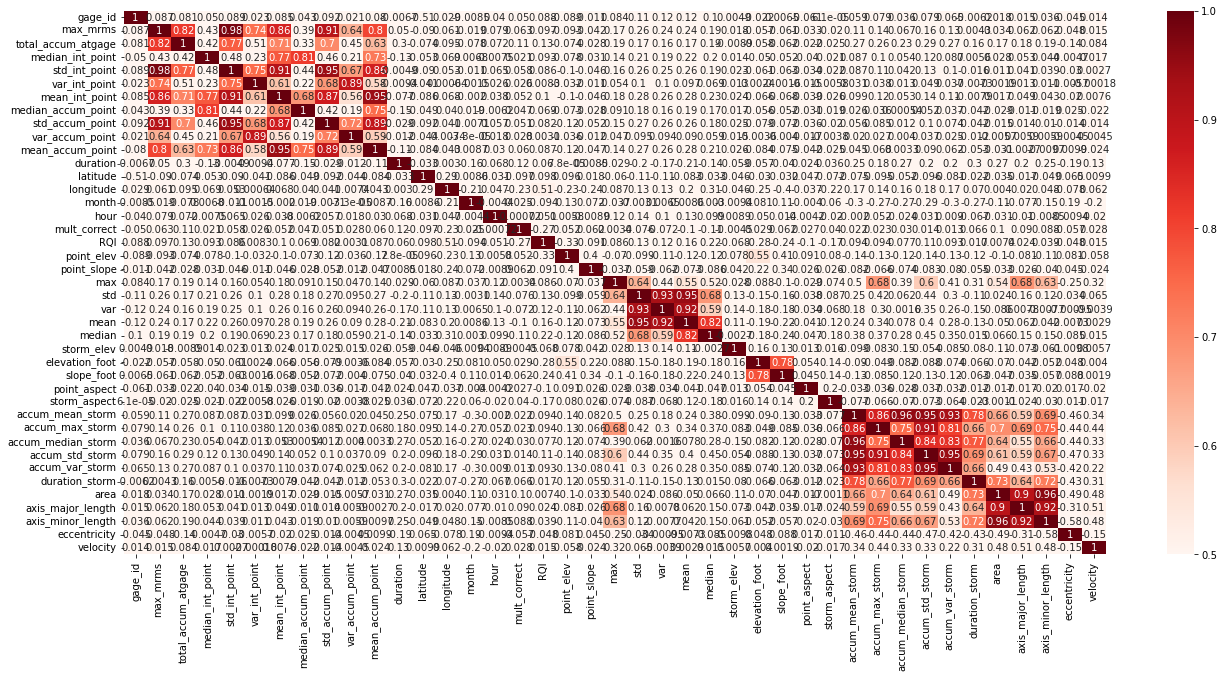

In [21]:
# look at feature correlation map
plt.figure(figsize=(22,10))
'''df = df.drop(columns = ['elevation_foot','std','accum_std_storm','accum_max_storm','var_int_point',
                        'mean_accum_point','median_accum_point','var_accum_point',
                        'std_int_point','mean','accum_mean_storm','axis_minor_length','std_accum_point'])'''

cor = df.drop(columns='label').corr()

sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,vmin=.5)
plt.show()

bin features

In [477]:
'''# bin latitude and longitude, include entire study area
bins = np.linspace(37.005,40.995,num=10)
labels = np.arange(0,9,1)

df['latitude'] = pd.cut(x = df['latitude'], bins = bins, labels = labels, include_lowest = True)

bins = np.linspace(250.954999,256,num=10)
labels = np.arange(0,9,1)

df['longitude'] = pd.cut(x = df['longitude'], bins = bins, labels = labels, include_lowest = True)'''


parameter tuning

In [36]:
clf = GradientBoostingClassifier(random_state=0)

mod = RandomizedSearchCV(estimator=clf,
                   param_distributions = {"learning_rate": [1, 0.5, 0.25, 0.1, 0.05, 0.01],
                                "n_estimators": [64, 100, 200,400],
                                "max_depth":range(1,11),
                                          "min_samples_split":range(2,8),
                                          "min_samples_leaf":range(1,8)},
                   n_iter=10, 
                   scoring="roc_auc",
                   refit="roc_auc",
                   cv=cv)

_ = mod.fit(X_train,y_train)  
pd.DataFrame(mod.cv_results_).sort_values('mean_test_score',ascending=False).params.reset_index().iloc[0].values

array([9,
       {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 6, 'learning_rate': 0.05}],
      dtype=object)

In [37]:
clf = RandomForestClassifier(random_state=0)

mod = RandomizedSearchCV(estimator=clf,
                   param_distributions = {"n_estimators": [64, 100, 200,400],
                                 "max_depth":range(1,11),
                                          "min_samples_split":range(2,8),
                                         "min_samples_leaf":range(1,8)},
                   n_iter=10, 
                   scoring="roc_auc",
                   refit="roc_auc",
                   cv=cv)

_ = mod.fit(X_train,y_train)  
pd.DataFrame(mod.cv_results_).sort_values('mean_test_score',ascending=False).params.reset_index().iloc[0].values

array([7,
       {'n_estimators': 400, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 10}],
      dtype=object)

In [38]:
clf = xgb.XGBClassifier(random_state=0)

mod = RandomizedSearchCV(estimator=clf,
                   param_distributions = {"learning_rate": [1, 0.5, 0.25, 0.1, 0.05, 0.01],
                                "n_estimators": [64, 100, 200,400],
                                "max_depth":range(1,11),
                                 'min_child_weight': [1, 5, 10],
                                 'gamma': [0.5, 1, 1.5, 2, 5],
                                 'subsample': [0.6, 0.8, 1.0],
                                 'colsample_bytree': [0.6, 0.8, 1.0],},
                   n_iter=10,               
                   scoring="roc_auc",
                   refit="roc_auc",
                   cv=cv)

_ = mod.fit(X_train,y_train)  
pd.DataFrame(mod.cv_results_).sort_values('mean_test_score',ascending=False).params.reset_index().iloc[0].values

array([6,
       {'subsample': 1.0, 'n_estimators': 64, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 1.0}],
      dtype=object)

In [11]:
names = [
    "Random Forest",
    "xgboost",
    "Gradient Boosting",
]

classifiers = [

    RandomForestClassifier(n_estimators=400, min_samples_split=3, min_samples_leaf=4, max_depth=10,random_state=0),
    xgb.XGBClassifier(subsample=1.0, n_estimators=64, min_child_weight=5, max_depth=6, learning_rate=0.1, gamma=0.5, 
                      colsample_bytree=1.0,random_state=0),
    GradientBoostingClassifier(n_estimators=200, min_samples_split=3, min_samples_leaf=2, max_depth=6, learning_rate=0.05,random_state=0),
]

In [19]:
# parameter tuning
f1 = []
accuracy = []
roc = []
precision = []
recall = []
good = []
f1_test = []
accuracy_test = []
roc_test = []
precision_test = []
recall_test = []

for name, clf in zip(names, classifiers):
    clf = clf
    clf.fit(X_train, y_train)
    x = cross_validate(clf,X_train, y_train, cv = cv,
                     scoring=['f1','accuracy','roc_auc','precision','recall'])
    
    f1.append(x['test_f1'].mean())
    accuracy.append(x['test_accuracy'].mean())
    roc.append(x['test_roc_auc'].mean())
    precision.append(x['test_precision'].mean())
    recall.append(x['test_recall'].mean())
    good.append(len(np.where(clf.predict(predict_s)==1)[0])/len(predict))
    f1_test.append(f1_score(y_test,clf.predict(X_test)))
    accuracy_test.append(accuracy_score(y_test,clf.predict(X_test)))
    roc_test.append(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]))
    precision_test.append(precision_score(y_test,clf.predict(X_test)))
    recall_test.append(recall_score(y_test,clf.predict(X_test)))
    
d = {'names':names,'f1':f1,'accuracy':accuracy,'roc_auc':roc,'precision':precision,'recall':recall,'good':good,'f1_test':f1_test,
    'accuracy_test':accuracy_test,'precision_test':precision_test,'recall_test':recall_test,'rocauc_test':roc_test}
pd.DataFrame(data=d).sort_values('accuracy_test',ascending=False)

,names,f1,accuracy,roc_auc,precision,recall,good,f1_test,accuracy_test,precision_test,recall_test,rocauc_test
1,xgboost,0.718525,0.725397,0.801511,0.718416,0.718909,0.718771,0.721767,0.725772,0.724089,0.719460,0.802255
2,Gradient Boosted,0.725449,0.731893,0.806081,0.724863,0.726289,0.675892,0.720714,0.725421,0.724856,0.716619,0.806866
0,Random Forest,0.706839,0.713194,0.785286,0.704890,0.709012,0.765224,0.705376,0.711376,0.712012,0.698864,0.788046


In [23]:
for name, clf in zip(names, classifiers):
    clf = clf
    clf.fit(X_train, y_train)
    print(np.sort(clf.feature_importances_))

[0.00807481 0.00822594 0.01250508 0.01278341 0.01310126 0.0131762
 0.01325366 0.01330675 0.01469776 0.01494917 0.01509289 0.01516622
 0.01530657 0.01549966 0.01572019 0.01590346 0.01601789 0.01647263
 0.01694823 0.01710786 0.01977281 0.02081058 0.02084275 0.02153024
 0.02331409 0.02359152 0.02437837 0.024709   0.02541771 0.02621049
 0.0266543  0.02915361 0.03141993 0.03335013 0.03448511 0.0437877
 0.05077002 0.06596449 0.07006833 0.10045922]
[0.         0.         0.01345589 0.0136104  0.01441994 0.01446617
 0.01462118 0.01486399 0.01489099 0.01492637 0.0163566  0.01671775
 0.01701614 0.01708698 0.0171807  0.0176164  0.01937189 0.01942157
 0.0200083  0.02021547 0.02042988 0.02061139 0.02173641 0.02280474
 0.02290311 0.02455802 0.02494797 0.02606311 0.02610384 0.02744213
 0.02863577 0.03168979 0.03171362 0.03265952 0.03293892 0.03338725
 0.04123959 0.05556813 0.06816341 0.11015672]
[0.0064183  0.00683916 0.00743837 0.00779401 0.00791414 0.00814582
 0.00879094 0.0087916  0.01022129 0.010

In [14]:
# recursive feature search, save feature importance
fi = []
for name, clf in zip(names, classifiers):
    clf = clf

    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="roc_auc",
        min_features_to_select=40,
        n_jobs=2,
    )
    rfecv.fit(X_train,y_train)

    feature_importances = pd.DataFrame(rfecv.estimator_.feature_importances_,
                                       index = df.drop(columns=['label','gage_id']).columns,
                                       columns=[name]).sort_values(name,
                                                                           ascending=False)

    fi.append(feature_importances)

In [15]:
index = df.drop(columns=['label','gage_id']).columns

In [ ]:
from sklearn.inspection import permutation_importance

Text(0.5, 0, 'Decrease in accuracy score')

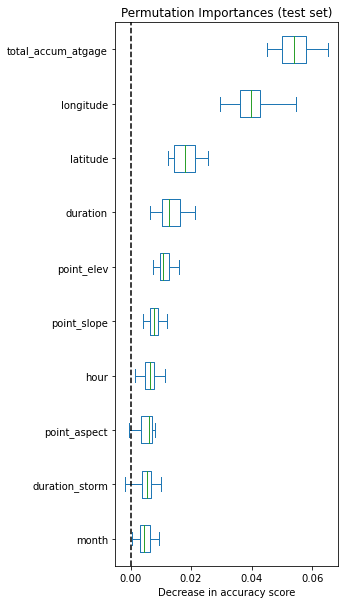

In [56]:
from sklearn.inspection import permutation_importance

model = classifiers[2].fit(X_train,y_train)

result = permutation_importance(
    model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=2
)

importance_idx = []
for i in result.importances_mean.argsort():
     if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        importance_idx.append(i)
        
importances = pd.DataFrame(
    result.importances[importance_idx].T,
    columns=index[importance_idx],
)

ax = importances.plot.box(vert=False, whis=10,figsize=(4,10))
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")


In [57]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [58]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.97


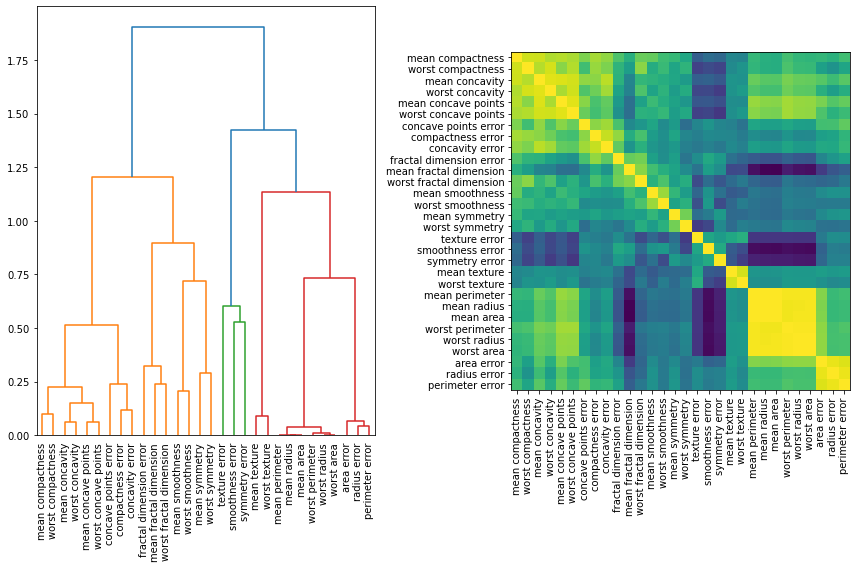

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [62]:
defaultdict(list)

defaultdict(list, {})

In [60]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Accuracy on test data with features removed: {:.2f}".format(
        clf_sel.score(X_test_sel, y_test)
    )
)

Accuracy on test data with features removed: 0.97


In [15]:
fi_preht = pd.concat(fi_preht,axis=1)

In [16]:
fi = pd.concat(fi,axis=1)

In [17]:
feature_importance = pd.concat([fi_preht,fi],axis=1).sort_values(['Gradient Boosting'],ascending=False)

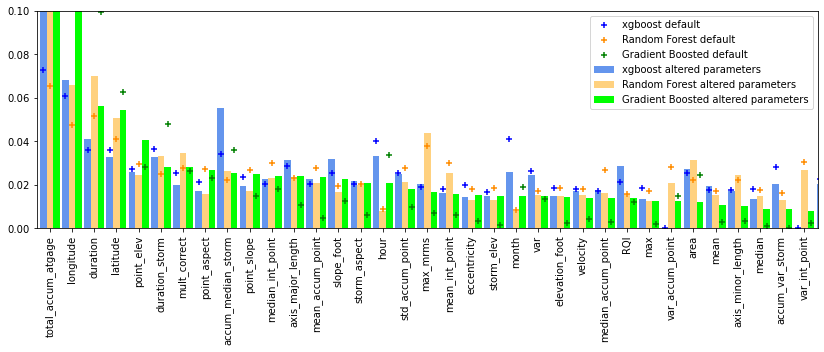

In [60]:
# compare feature importance pre and post parameter tuning
fig = plt.figure(figsize=(14,4))
bar_width = .3


index = np.arange(len(feature_importance))
plt.bar(index- bar_width,feature_importance.xgboost,bar_width,color='cornflowerblue',label='xgboost altered parameters')
plt.xticks(rotation=90)
plt.bar(index,feature_importance['Random Forest'],bar_width,color='orange',alpha=.5,label='Random Forest altered parameters')
plt.bar(index + bar_width,feature_importance['Gradient Boosting'],bar_width,color='lime',label='Gradient Boosting altered parameters')

plt.scatter(index- bar_width,feature_importance['xgboostprefsimportance'],color='blue',marker='+',label='xgboost default')
plt.scatter(index,feature_importance['Random Forestprefsimportance'],color='darkorange',marker='+',label='Random Forest default')
plt.scatter(index + bar_width,feature_importance['Gradient Boostingprefsimportance'],color='green',marker='+',label='Gradient Boosting default')
plt.xticks(index, feature_importance.index)
plt.legend()

plt.ylim(0,.1)
plt.xlim(0- bar_width*2,34+ bar_width*2)

fig.savefig("feature_importance.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

increase threshold for maximum intensity from zero

comment out df.drop(columns=['AR_peak','AR_accum']) above

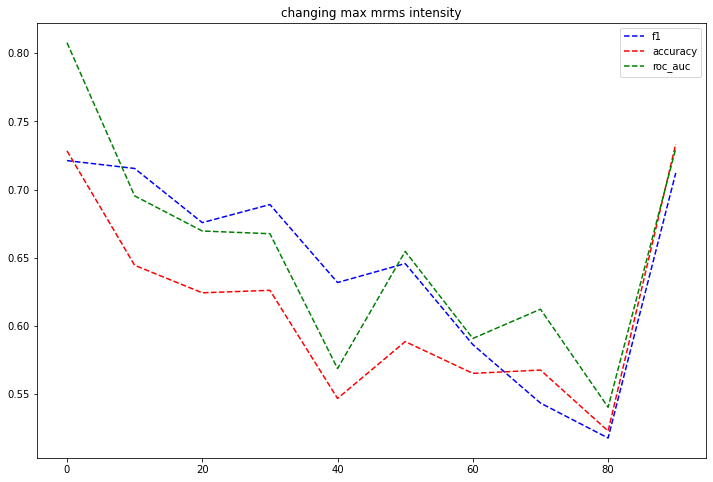

In [145]:
label_play = np.arange(0,100,10)

f11 = []
accuracy1 = []
roc1 = []
precision1 = []
recall1 = []

clf = xgb.XGBClassifier(subsample= 0.8, n_estimators= 64, min_child_weight= 1, 
                        max_depth= 8, learning_rate= 0.1, gamma= 1, colsample_bytree= 0.6)
    
for i in label_play:
    
    test = df.loc[df.max_mrms>=i] 
    test = test.drop(columns=['AR_peak','AR_accum'])
    
    data = test.drop(columns='label')
    labels = test.label.values

    data=scaler.fit_transform(data)
    
    x2 = cross_validate(clf,data,labels, cv = cv,
                 scoring=['f1','accuracy','roc_auc','precision','recall'])
    
    f11.append(x2['test_f1'].mean())
    accuracy1.append(x2['test_accuracy'].mean())
    roc1.append(x2['test_roc_auc'].mean())
    precision1.append(x2['test_precision'].mean())
    recall1.append(x2['test_recall'].mean())

fig = plt.figure(figsize=(12,8))

plt.plot(label_play,f11,'--b')
plt.plot(label_play,accuracy1,'--r')
plt.plot(label_play,roc1,'--g')
plt.legend(['f1','accuracy','roc_auc'])
plt.title('changing max mrms intensity')

fig.savefig("move_maxint.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

change label threshold

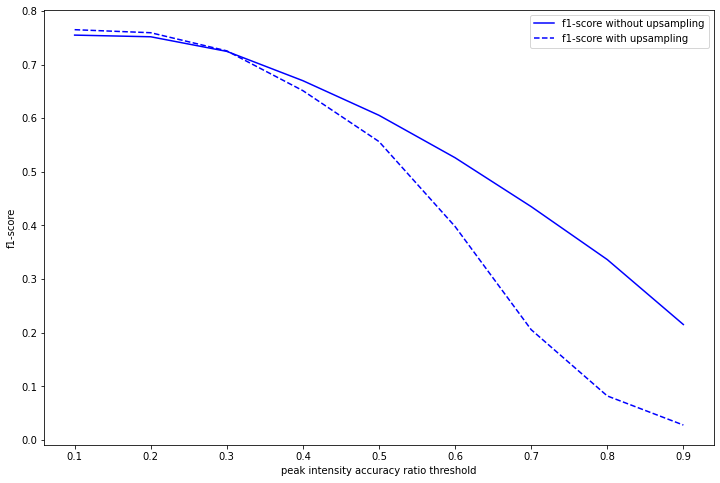

In [80]:
label_play = np.arange(0,1,0.1)
label_play = label_play[1:10]

f1 = []
f11 = []

clf = GradientBoostingClassifier(n_estimators=200, min_samples_split=3, min_samples_leaf=2,
                                 max_depth=6, learning_rate=0.05,random_state=0)
    
for i in label_play:
    sampler = RandomOverSampler(random_state=42)
    pipeline = Pipeline([('sampler', sampler),('gb', clf)])

    test = df
    test['label']=0
    test.loc[(test.AR_peak<=1/i)&(test.AR_peak>=i)&(test.AR_accum<=1/.25)&(test.AR_accum>=.25),['label']]=1
    test = test.drop(columns=['AR_peak','AR_accum'])
    
    data = test.drop(columns=['gage_id','label'])
    labels = test.label.values
    data=scaler.fit_transform(data)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    x1 = cross_validate(pipeline,X_train,y_train, cv = cv,
                     scoring=['f1'])
    x2 = cross_validate(clf,X_train,y_train, cv = cv,
                 scoring=['f1'])
    
    f1.append(x1['test_f1'].mean())
    f11.append(x2['test_f1'].mean())

# look at feature correlation map
fig = plt.figure(figsize=(12,8))
plt.plot(label_play,f1,'b',label='f1-score without upsampling')
plt.plot(label_play,f11,'--b',label='f1-score with upsampling')
plt.ylabel('f1-score')
plt.xlabel('peak intensity accuracy ratio threshold')

plt.legend()
plt.title('')

fig.savefig("move_label.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

Text(0.5, 1.0, 'changing max mrms intensity')

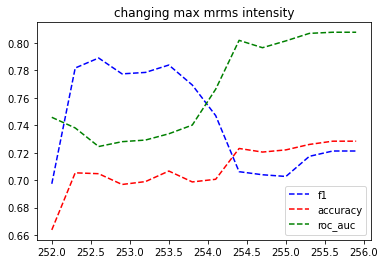

In [162]:
label_play = np.arange(252,256,.3)

f11 = []
accuracy1 = []
roc1 = []
precision1 = []
recall1 = []

clf = xgb.XGBClassifier(subsample= 0.8, n_estimators= 64, min_child_weight= 1, 
                        max_depth= 8, learning_rate= 0.1, gamma= 1, colsample_bytree= 0.6)
    
for i in label_play:
    
    test = df.loc[df.longitude<i]
    test = test.drop(columns=['AR_peak','AR_accum'])
    
    data = test.drop(columns='label')
    labels = test.label.values

    data=scaler.fit_transform(data)
    
    x2 = cross_validate(clf,data,labels, cv = cv,
                 scoring=['f1','accuracy','roc_auc','precision','recall'])
    
    f11.append(x2['test_f1'].mean())
    accuracy1.append(x2['test_accuracy'].mean())
    roc1.append(x2['test_roc_auc'].mean())
    precision1.append(x2['test_precision'].mean())
    recall1.append(x2['test_recall'].mean())


plt.plot(label_play,f11,'--b')
plt.plot(label_play,accuracy1,'--r')
plt.plot(label_play,roc1,'--g')
plt.legend(['f1','accuracy','roc_auc'])
plt.title('changing max mrms intensity')

move thresold to increase precision

C:\Users\whitep\Miniconda3\envs\radar\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
C:\Users\whitep\Miniconda3\envs\radar\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
C:\Users\whitep\Miniconda3\envs\radar\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


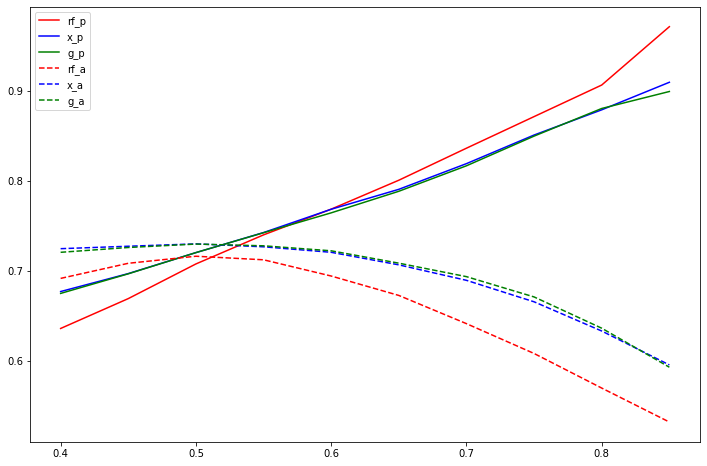

In [177]:
# see how different models change with shifting threshold
shift=[]
for name, clf in zip(names, classifiers):
    clf = clf
    
    pipe = Pipeline([
        ("model", Thresholder(clf, threshold=0.1))
    ])
    
    mod = GridSearchCV(estimator=pipe,
                       param_grid = {"model__threshold": np.arange(0.4, 0.9, .05)},
                       scoring={"precision": make_scorer(precision_score),
                                "recall": make_scorer(recall_score),
                                "accuracy": make_scorer(accuracy_score),
                               "f1":make_scorer(f1_score),
                               },
                       refit="precision",
                       cv=cv)

    _ = mod.fit(data, labels)    
    shift.append((pd.DataFrame(mod.cv_results_).set_index("param_model__threshold")[['mean_test_precision', 'mean_test_recall', 'mean_test_accuracy','mean_test_f1']]))


fig = plt.figure(figsize=(12,8))

plt.plot(pd.concat(shift,axis=1).mean_test_precision.iloc[:,0], 'r',label='rf_p')
plt.plot(pd.concat(shift,axis=1).mean_test_precision.iloc[:,1], 'b',label='x_p')
plt.plot(pd.concat(shift,axis=1).mean_test_precision.iloc[:,2], 'g',label='g_p')

plt.plot(pd.concat(shift,axis=1).mean_test_accuracy.iloc[:,0], 'r--',label='rf_a')
plt.plot(pd.concat(shift,axis=1).mean_test_accuracy.iloc[:,1], 'b--',label='x_a')
plt.plot(pd.concat(shift,axis=1).mean_test_accuracy.iloc[:,2], 'g--',label='g_a')

plt.legend()

fig.savefig("move_decision_threshold.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

roc curve

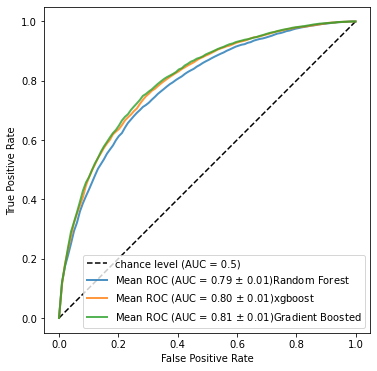

In [108]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([0, 1], [0, 1], "k--", label="random (AUC = 0.5)")
for name, clf in zip(names, classifiers):

    clf = clf

    tprs = []
    fprs = []
    aucs = []

    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train, test) in enumerate(cv.split(X_train,y_train)):
        clf.fit(X_train[train], y_train[train])
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])

        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc_score(y_train[test],probas_[:, 1]))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr,
        mean_tpr,

        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc) +name,
        lw=2,
        alpha=0.8,
    )
    ax.legend(loc="lower right")
    plt.axis("square")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
fig.savefig("roc.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

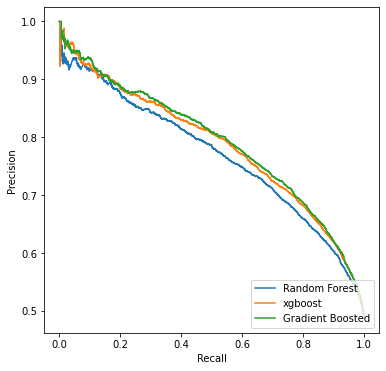

In [48]:
fig, ax = plt.subplots(figsize=(6, 6))
for name, clf in zip(names, classifiers):
    clf = clf
    y_probas = cross_val_predict(clf,X_train,y_train,cv=cv,method='predict_proba')
    
    p,r, thresholds = precision_recall_curve(y_train,y_probas[:,1])
    
    ax.plot(r,p, label=name)
    ax.legend(loc="lower right")
    
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    
#fig.savefig("pr_curve.pdf",
       #bbox_inches='tight',dpi=255,transparent=False,facecolor='white')


confusion matrix

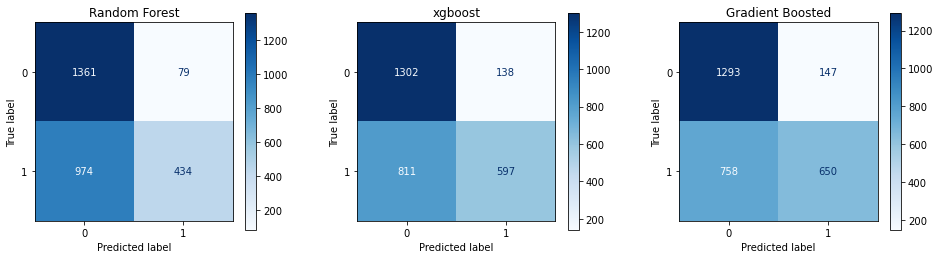

In [109]:
fig, axs = plt.subplots(1,3, figsize=(16,4), facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=.3)

axs = axs.ravel()    
i = 0
for name, clf in zip(names, classifiers):
    clf = clf
    pipe = Pipeline([
    ("model", Thresholder(clf, threshold=0.7))
    ])
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)

    cm=confusion_matrix(y_test,y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues',ax=axs[i])

    axs[i].set_title(name)
    i+=1
fig.savefig("confusionmatrix.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')    

calibration curve

In [28]:
from sklearn.metrics import mean_squared_error


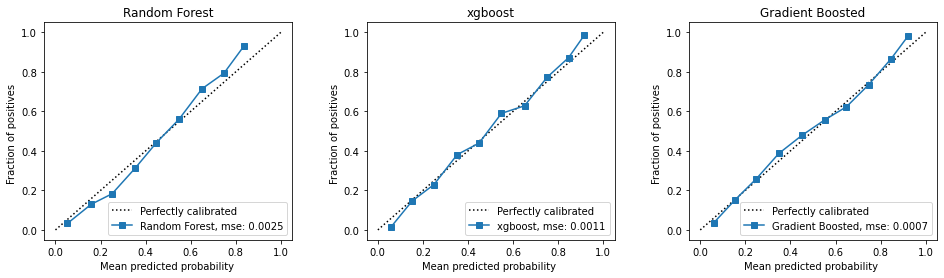

In [20]:
fig, axs = plt.subplots(1,3, figsize=(16,4), facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=.3)

axs = axs.ravel()    
i = 0

for name, clf in zip(names, classifiers):
    clf = clf
    
    '''pipe = Pipeline([
    ("model", Thresholder(clf, threshold=0.7))
    ])'''
    clf.fit(X_train,y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    
    mse = mean_squared_error(prob_true,prob_pred)
    
    disp = CalibrationDisplay(prob_true, prob_pred, y_prob, estimator_name=name+', mse: '+str(mse)[0:6])
    disp.plot(ax=axs[i])
    
    axs[i].set_title(name)
    i+=1
fig.savefig("calcurve.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')    

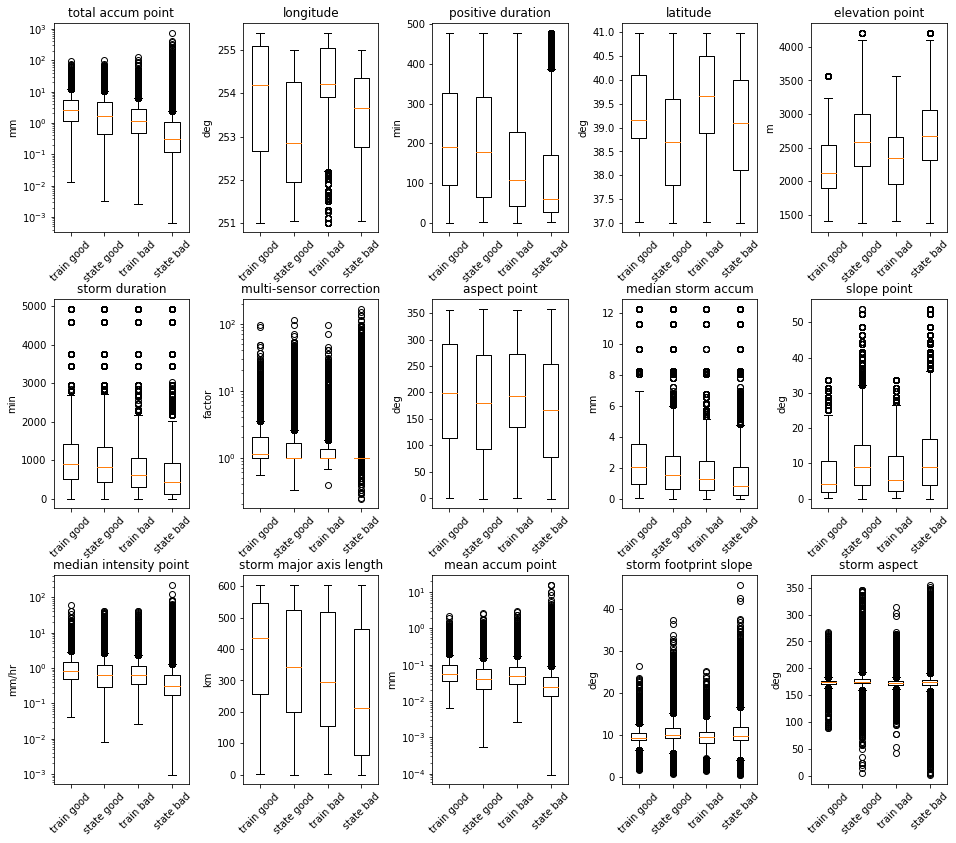

In [23]:
# plot top 10 most important features after paramter tuning

# sort df and predict by order of feature importance

fig, axs = plt.subplots(3,5, figsize=(16,14), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .32, wspace=.4)

axs = axs.ravel()

clf = GradientBoostingClassifier(n_estimators=200, min_samples_split=3, min_samples_leaf=2,
                                 max_depth=6, learning_rate=0.05,random_state=0)

pipe = Pipeline([
("model", Thresholder(clf, threshold=0.7))
])
pipe.fit(X_train,y_train)

state_p = pipe.predict(predict_s)
predict['label'] = state_p
state_good = predict.loc[predict.label==1]
state_bad = predict.loc[predict.label==0]

train_good = df.loc[df.label==1]
train_bad = df.loc[df.label==0]

make_log = [0,6,10,12]
y_label = ['mm','deg','min','deg','m',
           'min','factor','deg','mm','deg',
           'mm/hr','km','mm','deg','deg']
title = ['total accum point','longitude','positive duration','latitude','elevation point',
        'storm duration', 'multi-sensor correction','aspect point','median storm accum', 'slope point',
        'median intensity point','storm major axis length','mean accum point','storm footprint slope','storm aspect']

for i in range(15):
    column = feature_importance['Gradient Boosting'][0:15].index[i]

    d = [train_good[column],state_good[column],train_bad[column],state_bad[column]]
    axs[i].boxplot(d)
    axs[i].set_xticks([1,2,3,4],labels=['train good', 'state good','train bad','state bad'],rotation=45)
    axs[i].set_title(title[i])
    test = np.isin(i,make_log)
    
    if test == True:
        axs[i].set_yscale('log')


    axs[i].set_ylabel(y_label[i])
    
fig.savefig("spread.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

In [15]:
# plot top 10 most important features after paramter tuning
clf = GradientBoostingClassifier(n_estimators=200, min_samples_split=3, min_samples_leaf=2,
                                 max_depth=6, learning_rate=0.05,random_state=0)

pipe = Pipeline([
("model", Thresholder(clf, threshold=0.7))
])
pipe.fit(X_train,y_train)

state_p = pipe.predict_proba(predict_s)
predict['label_neg'] = state_p[:,0]
predict['label_pos'] = state_p[:,1]

In [16]:
predict.columns

Index(['max_mrms', 'total_accum_atgage', 'median_int_point', 'std_int_point',
       'var_int_point', 'mean_int_point', 'median_accum_point',
       'std_accum_point', 'var_accum_point', 'mean_accum_point', 'duration',
       'latitude', 'longitude', 'month', 'hour', 'mult_correct', 'RQI',
       'point_elev', 'point_slope', 'max', 'std', 'var', 'mean', 'median',
       'storm_elev', 'elevation_foot', 'slope_foot', 'point_aspect',
       'storm_aspect', 'accum_mean_storm', 'accum_max_storm',
       'accum_median_storm', 'accum_std_storm', 'accum_var_storm',
       'duration_storm', 'area', 'axis_major_length', 'axis_minor_length',
       'eccentricity', 'velocity', 'label_neg', 'label_pos'],
      dtype='object')

1180
833


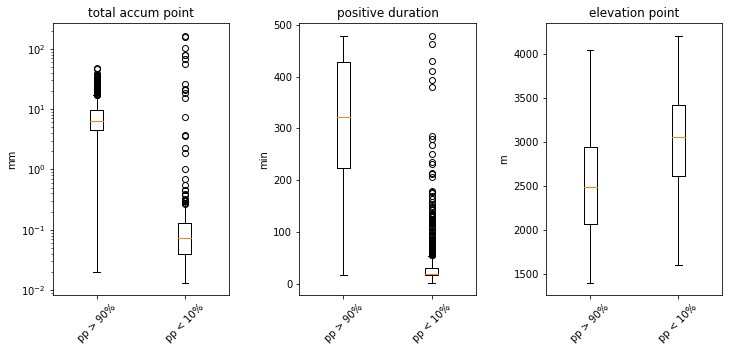

In [27]:
fig, axs = plt.subplots(1,3, figsize=(12,5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .32, wspace=.4)

axs = axs.ravel()

state_good = predict.loc[predict.label_pos>.9]
print(len(state_good))
state_bad = predict.loc[predict.label_pos<.1]
print(len(state_bad))

make_log = [0,6,10,12]
y_label = ['mm','min','m',
           'min','factor','deg','mm','deg',
           'mm/hr','km','mm','deg','deg']
title = ['total accum point','positive duration','elevation point',
        'storm duration', 'multi-sensor correction','aspect point','median storm accum', 'slope point',
        'median intensity point','storm major axis length','mean accum point','storm footprint slope','storm aspect']
#feature_importance_new = feature_importance.drop(index = ['latitude','longitude'])


fi = ['total_accum_atgage', 'duration','point_elev']

for i in range(3):
    #column = feature_importance_new['Gradient Boosted'][0:3].index[i]
    
    ######COMENT IF MODEL CHANGES, UNCOMMENT IF NOT RUNNING FEATURE IMPORTANCE
    column = fi[i]
    
    d = [state_good[column],state_bad[column]]
    axs[i].boxplot(d)
    axs[i].set_xticks([1,2],labels=['pp > 90%','pp < 10%'],rotation=45)
    axs[i].set_title(title[i])
    test = np.isin(i,make_log)
    
    if test == True:
        axs[i].set_yscale('log')


    axs[i].set_ylabel(y_label[i])
    
fig.savefig("spread_extremes.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')